![](https://media.licdn.com/dms/image/D4D12AQGU_0vXNy2KcA/article-cover_image-shrink_720_1280/0/1691093307457?e=1726099200&v=beta&t=b9S9B1pijG6vw6ULCrb7JSOH9eqLXsKmIDDWQMPgBvM)

# **TikTok Claim Classification Project**



## **PACE: Plan**

**Business Need and Modeling Objective**

TikTok users can report videos they believe violate the platform's terms of service. Given the sheer volume of videos created and viewed daily, it's impractical for human moderators to review every reported video.

Analysis shows that videos violating the terms of service are more likely to present claims rather than opinions. Thus, distinguishing between videos that make claims and those that express opinions is crucial.

TikTok aims to develop a machine learning model to identify claims and opinions in videos. Videos identified as opinions will be less likely to require human review. In contrast, videos identified as claims will undergo a further sorting process to prioritize those for human moderation. For instance, claim videos could be ranked by the number of reports they receive, with the top x% reviewed daily by human moderators.

This machine learning model will significantly enhance the efficiency of human moderators by presenting them with videos that are most likely to violate TikTok's terms of service.

**Modeling Design and Target Variable**

The dataset includes a column named claim_status, a binary indicator of whether a video is a claim or an opinion. This binary value will serve as the target variable for the model, which will predict whether each video is a claim or an opinion.

This task involves binary classification, as the model will classify videos into one of two categories.

**Selecting an Evaluation Metric**

To choose an appropriate evaluation metric, consider the types of prediction errors:

- **False positives:** The model predicts a video is a claim when it is actually an opinion.
- **False negatives:** The model predicts a video is an opinion when it is actually a claim.

The machine learning model will be instrumental in presenting human moderators with videos that are most likely to violate TikTok's terms of service.

**Modeling Workflow and Model Selection Process**

Previous analysis of this dataset, which contains approximately 20,000 videos, has shown that it is ample for thorough model validation. The modeling workflow is structured as follows:

   1. Split the data into training, validation, and test sets (60/20/20).
   2. Fit models and tune hyperparameters using the training set.
   3. Perform final model selection using the validation set.
   4. Assess the performance of the chosen model on the test set.
    

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)

### **Task 1. Imports and data loading**

Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [1]:
import numpy as np
import pandas as pd

# Suppress the specific FutureWarning in Kaggle notebook
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na option is deprecated")
warnings.filterwarnings("ignore", category=FutureWarning, message="When grouping with a length-1 list-like")


# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# Data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample

# Statistical analysis/hypothesis testing
from scipy import stats

# Metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree

# For saving models
import pickle

In [2]:
# Load dataset into dataframe
data = pd.read_csv('/kaggle/input/tiktok-content/tiktok_video_metrics.csv')

## **PACE: Analyze**

### **Understanding and inspecting data**

In [3]:
# Display and examine the first ten rows of the dataframe
data.head(10)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0
5,6,claim,8972200955,35,someone shared with me that gross domestic pro...,not verified,under review,336647.0,175546.0,62303.0,4293.0,1857.0
6,7,claim,4958886992,16,someone shared with me that elvis presley has ...,not verified,active,750345.0,486192.0,193911.0,8616.0,5446.0
7,8,claim,2270982263,41,someone shared with me that the best selling s...,not verified,active,547532.0,1072.0,50.0,22.0,11.0
8,9,claim,5235769692,50,someone shared with me that about half of the ...,not verified,active,24819.0,10160.0,1050.0,53.0,27.0
9,10,claim,4660861094,45,someone shared with me that it would take a 50...,verified,active,931587.0,171051.0,67739.0,4104.0,2540.0


Each row represents a record for a particular ID or user's claim, containing detailed information about the video, duration, views, likes, shares, downloads, and comments. The dataset includes a mix of categorical, text, and numerical data.

In [4]:
# Get summary info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


The variables are of different types. There are numerical 3x integer, 5x float, and  4x object. Notably, there are some null values present in several variables.

In [5]:
description = data.describe().T

description.style.format('{:,.2f}')

,count,mean,std,min,25%,50%,75%,max
#,"19,382.00","9,691.50","5,595.25",1.00,"4,846.25","9,691.50","14,536.75","19,382.00"
video_id,"19,382.00","5,627,454,067.34","2,536,440,464.17","1,234,959,018.00","3,430,416,807.25","5,618,663,579.00","7,843,960,211.25","9,999,873,075.00"
video_duration_sec,"19,382.00",32.42,16.23,5.00,18.00,32.00,47.00,60.00
video_view_count,"19,084.00","254,708.56","322,893.28",20.00,"4,942.50","9,954.50","504,327.00","999,817.00"
video_like_count,"19,084.00","84,304.64","133,420.55",0.00,810.75,"3,403.50","125,020.00","657,830.00"
video_share_count,"19,084.00","16,735.25","32,036.17",0.00,115.00,717.00,"18,222.00","256,130.00"
video_download_count,"19,084.00","1,049.43","2,004.30",0.00,7.00,46.00,"1,156.25","14,994.00"
video_comment_count,"19,084.00",349.31,799.64,0.00,1.00,9.00,292.00,"9,599.00"


Comments and views almost reached a million, with some entries showing outliers. There are peaks in shares, likes, downloads, and comments in certain entries. These variables have very large standard deviations and extremely high maximum values compared to their quartile values.

### **Variables investigation**

A good initial step in understanding the data is to examine the 'claim_status' variable. Start by determining the number of videos corresponding to each claim status.

**Claim status**

In [6]:
# What are the different values for claim status and how many of each are in the data?
claim_status_counts = (data['claim_status'].value_counts())
print(claim_status_counts)
print()
claim_status_percentage = (claim_status_counts/claim_status_counts.sum())*100
print(claim_status_percentage)
print()

# Specify the two classes we want to compare
class_1 = 'claim'
class_2 = 'opinion'

# Calculate the difference between the counts of the two classes
difference = claim_status_counts[class_1] - claim_status_counts[class_2]

total_counts = claim_status_counts.sum()
    
# Calculate the percentage difference
percentage_difference = (difference / total_counts) * 100
    
print(f"The absolute difference between {class_1} and {class_2} is: {difference}")
print(f"The percentage difference between {class_1} and {class_2} is: {percentage_difference:.2f}%")


claim_status
claim      9608
opinion    9476
Name: count, dtype: int64

claim_status
claim      50.345839
opinion    49.654161
Name: count, dtype: float64

The absolute difference between claim and opinion is: 132
The percentage difference between claim and opinion is: 0.69%


The counts for each claim status are well-balanced, that is reflected to a minimal percentage difference of 0.69%.

Next, examine the engagement trends associated with each different claim status.

We can start with Boolean masking to filter the data based on claim status, followed by calculating the mean and median view counts for each category.

**Claim**

In [7]:
# What is the average view count of videos with "claim" status?
data_claim = data['claim_status'] =='claim'

claims = data[data['claim_status'] == 'claim']
print('Mean view count claims:', round(claims['video_view_count'].mean(),2))
print('Median view count claims:', claims['video_view_count'].median())

Mean view count claims: 501029.45
Median view count claims: 501555.0


**Opinion**

In [8]:
# What is the average view count of videos with "opinion" status?
data_opinion = data['claim_status'] =='opinion'
#mean and median were in both categories really close to each other, almost identical.
#there is great count differenece between claims and opinions

opinions = data[data['claim_status'] == 'opinion']
print('Mean view count opinions:', opinions['video_view_count'].mean())
print('Median view count opinions:', opinions['video_view_count'].median())

Mean view count opinions: 4956.43224989447
Median view count opinions: 4953.0


The mean and median values within each claim category are similar, but there is a significant difference in view counts between videos labeled as claims and those labeled as opinions.

Now, examine trends associated with the ban status of the author.

Calculate the number of videos for each combination of claim status and author ban status categories.

In [9]:
data.groupby(['claim_status', 'author_ban_status']).count()[['#']]

#
claim_status author_ban_status      
claim        active             6566
             banned             1439
             under review       1603
opinion      active             8817
             banned              196
             under review        463

Claim videos are more strictly policed than opinion videos, requiring authors to adhere to a stricter set of rules when posting a claim compared to an opinion. It is important to note that we cannot determine whether claim videos are inherently more likely than opinion videos to result in author bans or if authors who post claim videos are simply more prone to violating terms of service.

Additionally, while this data allows us to draw conclusions about banned versus active authors, it does not provide insights into banned videos. We cannot ascertain if a specific video led to the ban, as banned authors may have posted other videos that complied with the terms of service.

In [10]:
# What's the median video share count of each author ban status?
data.groupby(['author_ban_status']).median(numeric_only=True)[['video_share_count']]

,video_share_count
author_ban_status,
active,437.0
banned,14468.0
under review,9444.0


Although banned accounts are fewer in number compared to active ones, they have higher median and average views, likes, and shares. Banned authors, in particular, have a median share count that is 33 times greater than that of active authors.

In [11]:
data.groupby(['author_ban_status']).agg(
    {'video_view_count': ['count', 'mean', 'median'],
     'video_like_count': ['count', 'mean', 'median'],
     'video_share_count': ['count', 'mean', 'median']
     })

video_view_count                          video_like_count  \
                             count           mean    median            count   
author_ban_status                                                              
active                       15383  215927.039524    8616.0            15383   
banned                        1635  445845.439144  448201.0             1635   
under review                  2066  392204.836399  365245.5             2066   

                                           video_share_count                \
                            mean    median             count          mean   
author_ban_status                                                            
active              71036.533836    2222.0             15383  14111.466164   
banned             153017.236697  105573.0              1635  29998.942508   
under review       128718.050339   71204.5              2066  25774.696999   

                            
                    median  
author_ban_status           
active               437.0  
banned             14468.0  
under review        9444.0

Banned authors and those under review receive significantly more views, likes, and shares compared to active authors. In most groups, the mean is substantially higher than the median, suggesting the presence of videos with exceptionally high engagement counts or large upper outliers.

Let's create engagement columns to gain a clearer understanding of their actual rates.

In [12]:
# Likes_per_view column
data['likes_per_view'] = data['video_like_count']/data['video_view_count']

# Comments_per_view column
data['comments_per_view'] = data['video_comment_count']/data['video_view_count']

# Shares_per_view column
data['shares_per_view'] = data['video_share_count']/ data['video_view_count']

We can analyze engagement metrics grouped by claim_status and author_ban_status

In [13]:
# Engagement metrics by claim_status & author_ban_status
data.groupby(['claim_status','author_ban_status']).agg(
    {'likes_per_view': ['count','mean', 'median'],
    'comments_per_view':['count','mean', 'median'],
    'shares_per_view':['count','mean', 'median']})

likes_per_view                      \
                                        count      mean    median   
claim_status author_ban_status                                      
claim        active                      6566  0.329542  0.326538   
             banned                      1439  0.345071  0.358909   
             under review                1603  0.327997  0.320867   
opinion      active                      8817  0.219744  0.218330   
             banned                       196  0.206868  0.198483   
             under review                 463  0.226394  0.228051   

                               comments_per_view                      \
                                           count      mean    median   
claim_status author_ban_status                                         
claim        active                         6566  0.001393  0.000776   
             banned                         1439  0.001377  0.000746   
             under review                   1603  0.001367  0.000789   
opinion      active                         8817  0.000517  0.000252   
             banned                          196  0.000434  0.000193   
             under review                    463  0.000536  0.000293   

                               shares_per_view                      
                                         count      mean    median  
claim_status author_ban_status                                      
claim        active                       6566  0.065456  0.049279  
             banned                       1439  0.067893  0.051606  
             under review                 1603  0.065733  0.049967  
opinion      active                       8817  0.043729  0.032405  
             banned                        196  0.040531  0.030728  
             under review                  463  0.044472  0.035027

We observe that videos by banned authors and those under review generally attract significantly more views, likes, and shares compared to videos by non-banned authors. However, once a video is viewed, its engagement rate is more strongly influenced by its claim status than by the author's ban status.

Additionally, claim videos have a higher view rate compared to opinion videos, and they also receive a higher average rate of likes, indicating they are more favorably received. Moreover, claim videos garner more engagement through comments and shares than opinion videos.

For claim videos, banned authors achieve slightly higher likes-to-view and shares-to-view rates than active authors or those under review. In contrast, for opinion videos, active authors and those under review achieve higher engagement rates across all categories compared to banned authors.

###  Build visualizations

#### **Video duration**

Create a box plot to analyze the range of values in video duration and a histogram to further investigate the distribution of these values.

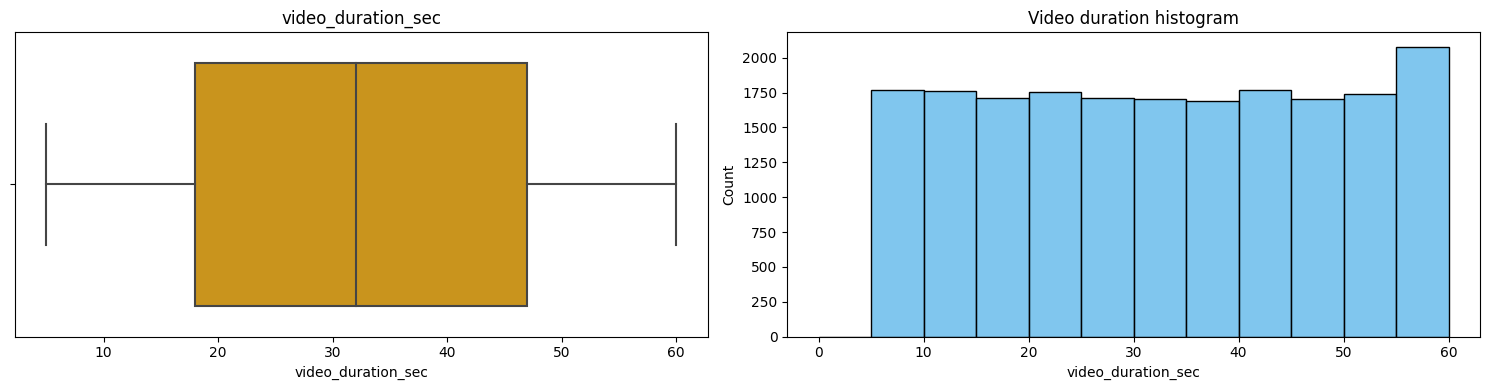

In [14]:
# Colors from the Color Universal Design (CUD) palette
cud_box_color = '#E69F00'  # Orange
cud_hist_color = '#56B4E9'  # Sky Blue

# Figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# First subplot: Boxplot
axes[0].set_title('video_duration_sec')
sns.boxplot(x=data['video_duration_sec'], ax=axes[0], color=cud_box_color)

# Second subplot: Histogram 
sns.histplot(data['video_duration_sec'], bins=range(0, 61, 5), ax=axes[1], color=cud_hist_color)
axes[1].set_title('Video duration histogram')

# Adjust layout to prevent overlap
plt.tight_layout()



All videos have durations ranging from 5 to 60 seconds, with a uniformly distributed length.

#### **Video views**

Create a box plot to examine the spread of values in video views and histogram of this variable to explore the distribution.

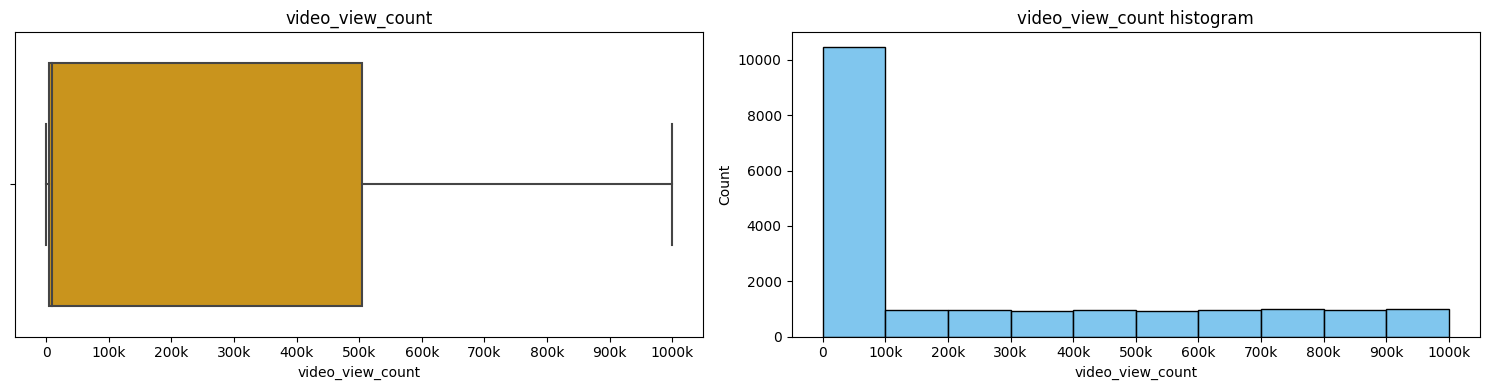

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Define labels for labels for view count categories from 0 to 1000k in increments of 100k
labels = [0] + [str(i) + 'k' for i in range(100, 1001, 100)]

axes[0].set_title('video_view_count')
sns.boxplot(x=data['video_view_count'], ax=axes[0], color=cud_box_color)
axes[0].set_xticks(range(0, 10*10**5 + 1, 10**5)) # Set x-axis ticks from 0 to 1,000,000 in increments of 100,000
axes[0].set_xticklabels(labels)

sns.histplot(data['video_view_count'], bins=range(0,(10**6+1),10**5), ax=axes[1], color=cud_hist_color)
axes[1].set_title('video_view_count histogram')
axes[1].set_xticks(range(0, 10*10**5 + 1, 10**5))
axes[1].set_xticklabels(labels)

plt.tight_layout()

This variable exhibits a highly uneven distribution, with more than half of the videos receiving fewer than 100,000 views. For view counts greater than 100,000, the distribution is uniform.

#### **Video likes**

Create a box plot to examine the spread of values in video likes and histogram to explore the distribution.

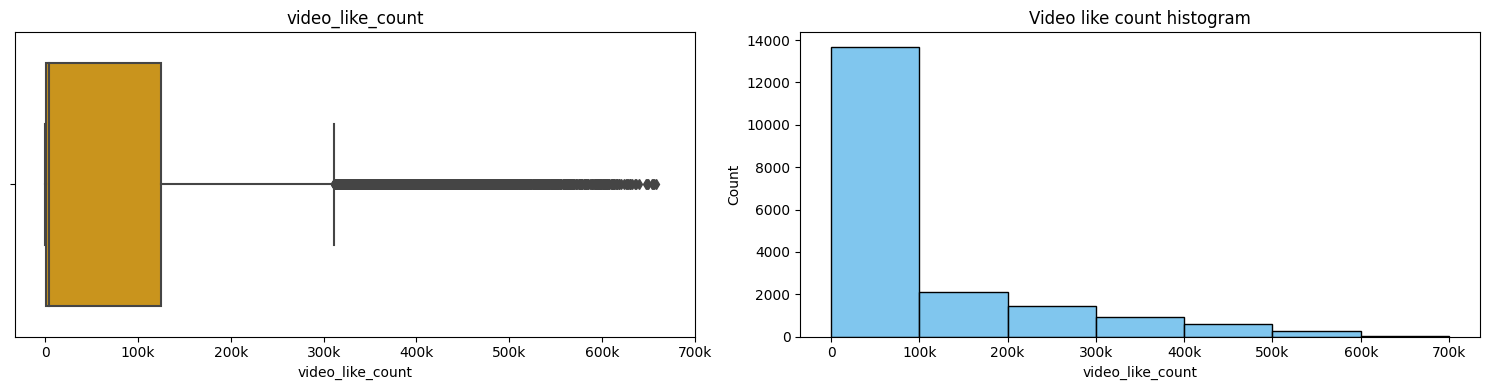

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

labels = [0] + [str(i) + 'k' for i in range(100, 701, 100)]

axes[0].set_title('video_like_count')
sns.boxplot(x=data['video_like_count'], ax=axes[0], color=cud_box_color)
axes[0].set_xticks(range(0, 7*10**5 + 1, 10**5))
axes[0].set_xticklabels(labels)

sns.histplot(data['video_like_count'], bins=range(0, 7*10**5 + 1, 10**5), ax=axes[1], color=cud_hist_color)
axes[1].set_title('Video like count histogram')
axes[1].set_xticks(range(0, 7*10**5 + 1, 10**5))
axes[1].set_xticklabels(labels)

plt.tight_layout();

Similar to view counts, there are significantly more videos with fewer than 100,000 likes compared to those with more. However, the distribution tapers off, with the data skewing to the right, resulting in many videos having extremely high like counts.

#### Video comments

Create a box plot to examine the spread of values in the video comments & histogram to further explore the distribution.

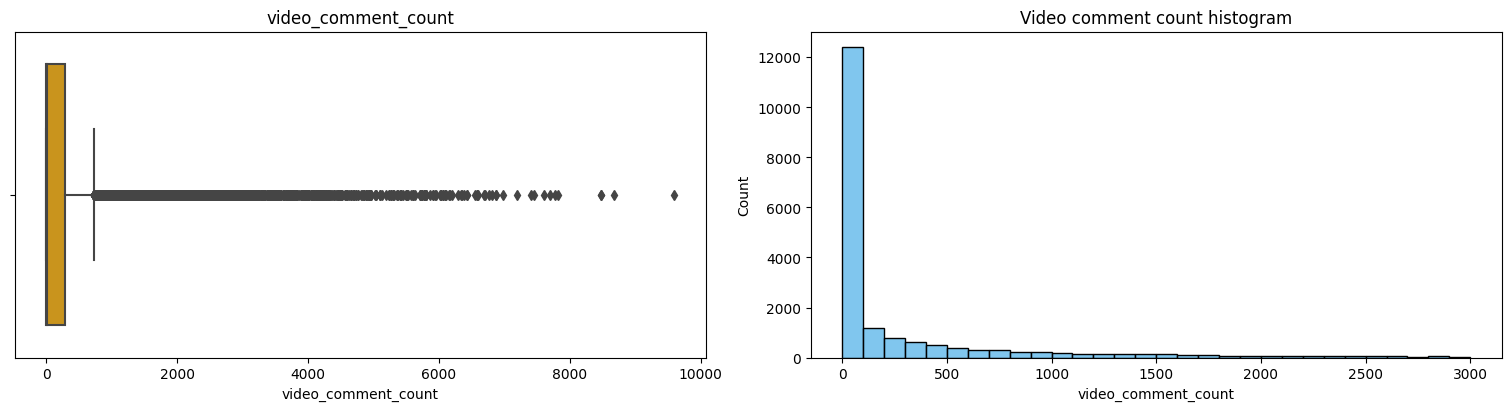

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), constrained_layout=True)

hist_labels = [str(i) for i in range(0, 3001, 500)]

ax1.set_title('video_comment_count')
sns.boxplot(x=data['video_comment_count'], ax=ax1, color=cud_box_color)

sns.histplot(data['video_comment_count'], bins=range(0, 3001, 100), ax=ax2, color=cud_hist_color)
ax2.set_title('Video comment count histogram')
ax2.set_xticks(range(0, 3001, 500))
ax2.set_xticklabels(hist_labels);

The majority of videos have comment counts clustered at the lower end of the range. Most videos have fewer than 100 comments, resulting in a highly right-skewed distribution.

#### Video shares

Create a boxplot to examine the spread of values of video shares and histogram to further explore the distribution.

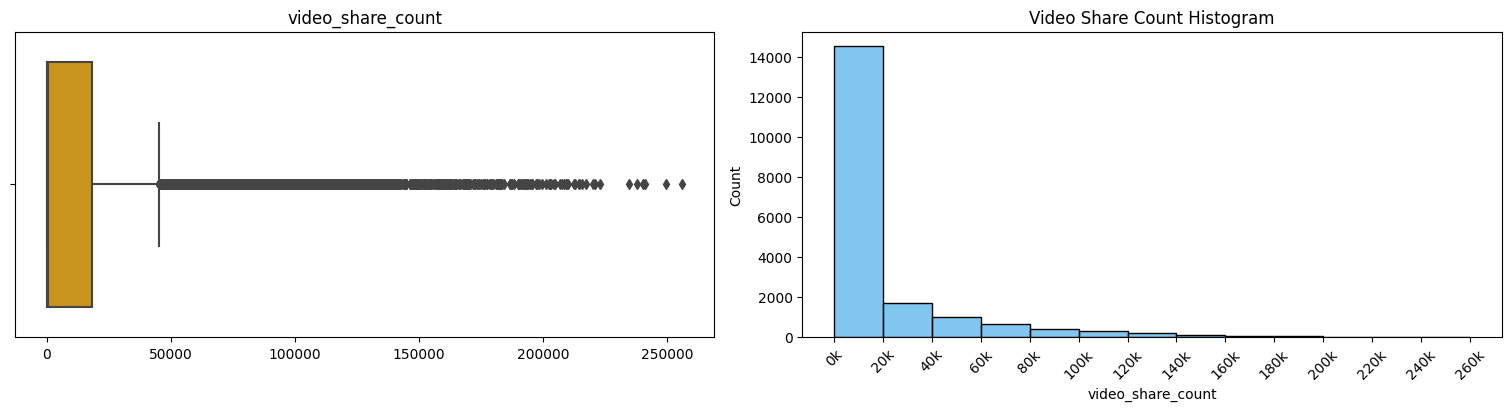

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4), constrained_layout=True)

# Labeling values in a more compact form, discards the remainder, giving the number of thousands.
hist_labels = [f'{i//1000}k' for i in range(0, 270001, 20000)]

axes[0].set_title('video_share_count')
sns.boxplot(x=data['video_share_count'], ax=axes[0], color=cud_box_color)
axes[0].set_xlabel('')  # Optionally remove x-axis label if not needed

sns.histplot(data['video_share_count'], bins=range(0, 270001, 20000), ax=axes[1], color=cud_hist_color)
axes[1].set_title('Video Share Count Histogram')

axes[1].set_xticks(range(0, 270001, 20000))
axes[1].set_xticklabels(hist_labels)

# Optional: Rotate x-axis labels for better readability
axes[1].tick_params(axis='x', rotation=45);

Most videos had fewer than 10,000 shares, resulting in a distribution that is highly right-skewed.

#### Video downloads

Create a boxplot to examine the spread of values in video downloads and histogram further explore the distribution.

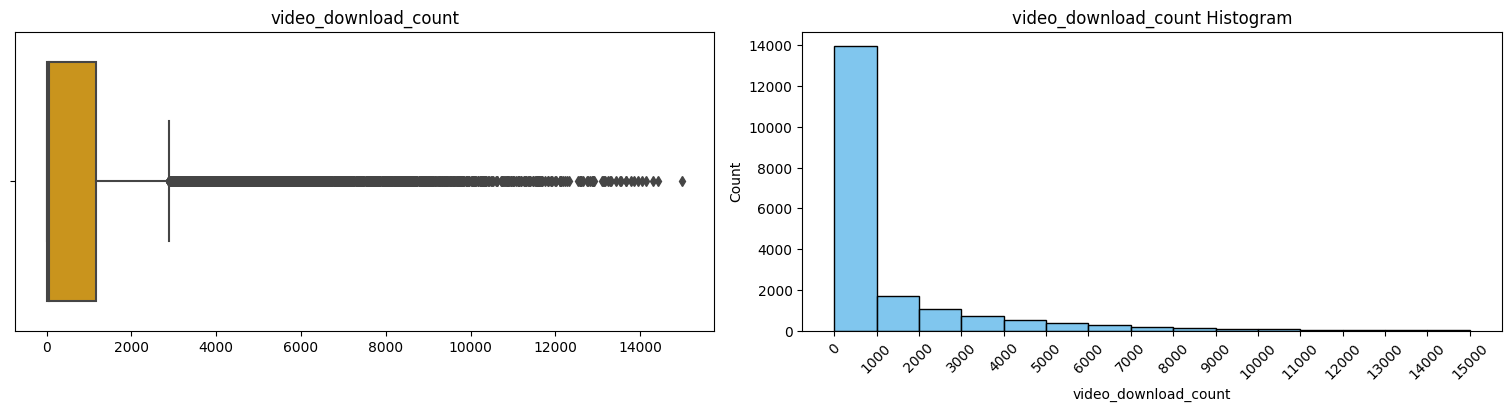

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4), constrained_layout=True)

hist_labels =  [str(i) for i in range(0,(15001),1000)]

axes[0].set_title('video_download_count')
sns.boxplot(x=data['video_download_count'], ax=axes[0], color=cud_box_color)
axes[0].set_xlabel('')  # Optionally remove x-axis label if not needed

sns.histplot(data['video_download_count'], bins=range(0,(15001),1000), ax=axes[1], color=cud_hist_color)
axes[1].set_title('video_download_count Histogram')

axes[1].set_xticks(range(0,(15001),1000))
axes[1].set_xticklabels(hist_labels)

axes[1].tick_params(axis='x', rotation=45);

Most videos were downloaded fewer than 500 times, though some received over 12,000 downloads. This indicates a significant rightward skew in the data.

#### **Claim status by verification status**

Create a histogram featuring four bars, with each bar representing a unique combination of claim status and verification status.

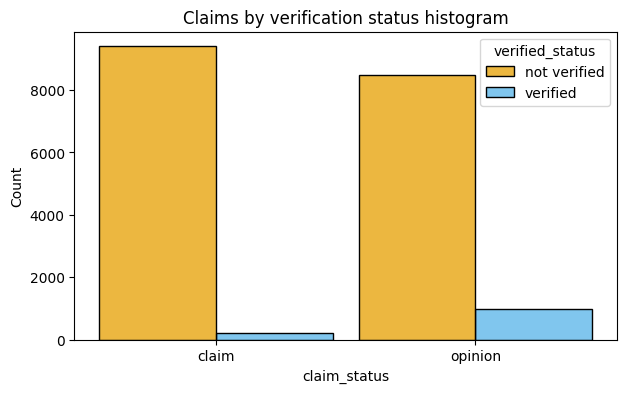

In [20]:
# Color Universal Design (CUD) palette
cud_palette = ['#E69F00', '#56B4E9']

plt.figure(figsize=(7, 4))

sns.histplot(data=data,
             x='claim_status',
             hue='verified_status',
             multiple='dodge',
             shrink=0.9,
             palette=cud_palette)

plt.title('Claims by verification status histogram');

There are significantly fewer verified users compared to unverified ones; however, verified users are substantially more likely to post opinions.

#### Claim status by author ban status

Create a histogram to examine the count of each claim status for each author ban status.

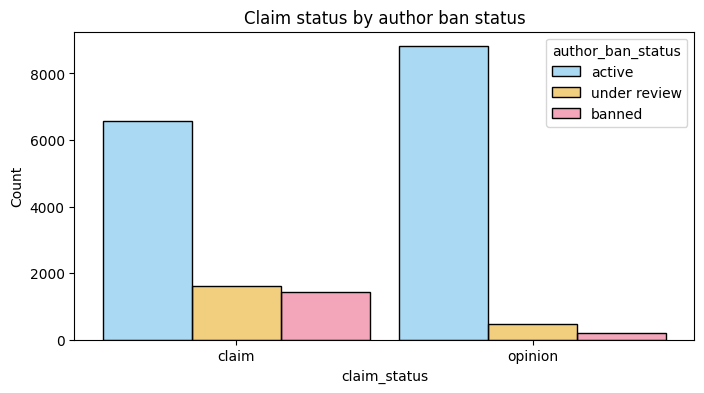

In [21]:
cud_palette = {
    'active': '#56B4E9',       # Sky Blue
    'under review': '#E69F00', # Orange
    'banned': '#E94E77'        # Fiery Red
}

fig = plt.figure(figsize=(8, 4))

sns.histplot(data, x='claim_status', hue='author_ban_status',
             multiple='dodge',
             hue_order=['active', 'under review', 'banned'],
             shrink=0.9,
             palette=cud_palette,
             alpha=0.5)

plt.title('Claim status by author ban status');

For both claim and opinion videos, there are significantly more active authors than banned authors or those under review. However, the proportion of active authors is notably higher for opinion videos compared to claim videos. This suggests that authors who post claim videos are more likely to face review or banning.

#### **Median view counts by ban status**

Generate a bar plot with three bars, each representing a different author ban status. The height of each bar should reflect the median number of views for videos associated with that particular author ban status.

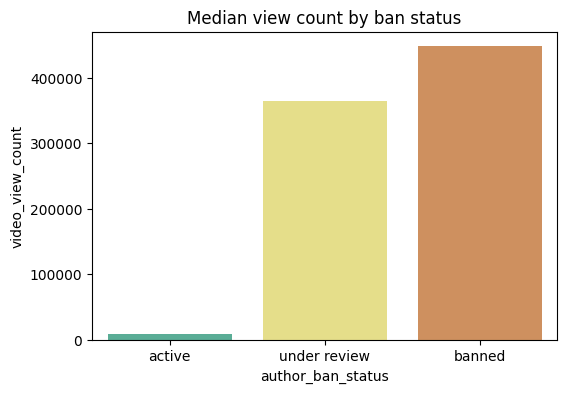

In [22]:
color_palette = {
    'active': '#009E73',      # Green
    'under review': '#F0E442', # Yellow
    'banned': '#D55E00'       # Red
}

# Group and calculate the median values
ban_status_counts = data.groupby(['author_ban_status']).median(numeric_only=True).reset_index()
fig = plt.figure(figsize=(6, 4))
sns.barplot(
    data=ban_status_counts,
    x='author_ban_status',
    y='video_view_count',
    order=['active', 'under review', 'banned'],
    palette=color_palette,
    alpha=0.7
)
plt.title('Median view count by ban status');

The median view counts for inactive authors are substantially higher than those for active authors. Considering that inactive authors are more susceptible to post claims and that their videos accumulate significantly more views overall than those of active authors,`video_view_count` may be an effective indicator of claim status.

In [23]:
data.groupby('claim_status')['video_view_count'].median()

claim_status
claim      501555.0
opinion      4953.0
Name: video_view_count, dtype: float64

In fact, a quick examination of the median view count by claim status supports this conclusion.

#### **Total views by claim status**

Create a pie graph that depicts the proportions of total views for claim videos and total views for opinion videos.

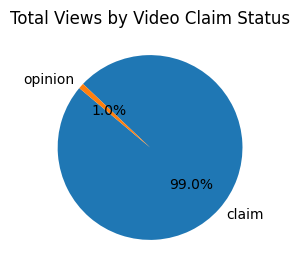

In [24]:
fig = plt.figure(figsize=(3, 3))
plt.pie(data.groupby('claim_status')['video_view_count'].sum(),labels=['claim', 'opinion'],
    autopct='%1.1f%%',  # Show percentages on the pie chart
    startangle=140  # Start angle to ensure consistent orientation
)
plt.title('Total Views by Video Claim Status');

The overall view count is dominated by claim videos even though there are roughly the same number of each video in the dataset.

**Importance of Handling Outliers in Predictive Models**

Outliers can pose significant challenges when constructing predictive models. For instance, if the goal is to forecast the view count of a video, those with exceptionally high view counts might skew the model's predictions. Additionally, outliers may signal issues in data collection or recording processes.

**Objective of the TikTok Project**

The primary goal of the TikTok project is to develop a model that can predict whether a video is classified as a claim or an opinion. Our analysis has shown a strong correlation between a video's engagement level and its claim status. There is no evidence suggesting that the TikTok data contains inaccurately recorded values, and the distribution aligns with expected social media patterns: a small fraction of videos achieve extremely high engagement, reflecting the nature of viral content.

**Importance of Identifying Outliers**

The approach to handling outliers should be tailored to the project's requirements, leveraging field knowledge to set appropriate thresholds. A common method for identifying outliers in a normally distributed dataset is to use the interquartile range (IQR), defining outliers as those beyond 1.5 times the IQR above the third quartile.

**Adapting Outlier Detection for the TikTok Dataset**

In the TikTok dataset, the count variables are heavily right-skewed rather than normally distributed. To adjust the outlier threshold accordingly, one can calculate the median value for each variable and add 1.5 times the IQR. This results in a lower threshold compared to using the third quartile, better reflecting the dataset's skewed nature.

**Steps:**

1. Calculate the IQR of the column
2. Calculate the median of the column
3. Determine the outlier threshold using the formula: median + 1.5 * IQR.
4. Count the number of videos with values in that column exceeding the outlier threshold.

In [25]:
# List of column names related to video metrics
count_cols = [
    'video_view_count',
    'video_like_count',
    'video_share_count',
    'video_download_count',
    'video_comment_count',
]

# Iterate through each column in the list 'count_cols'
for column in count_cols:
    # Calculate the first quartile (25th percentile) of the column data
    q1 = data[column].quantile(0.25)
    # Calculate the third quartile (75th percentile) of the column data
    q3 = data[column].quantile(0.75)
    # Calculate the interquartile range (IQR) as the difference between Q3 and Q1
    iqr = q3 - q1
    # Find the median (50th percentile) of the column data
    median = data[column].median()
    # Define an outlier threshold as 1.5 times the IQR above the median
    outlier_threshold = median + 1.5 * iqr

    # Count the number of values in the column that exceed the outlier threshold
    outlier_count = (data[column] > outlier_threshold).sum()
    # Print the count of outliers for the current column
    print(f'Outliers of {column}:', outlier_count)
 

Outliers of video_view_count: 2343
Outliers of video_like_count: 3468
Outliers of video_share_count: 3732
Outliers of video_download_count: 3733
Outliers of video_comment_count: 3882


#### **Scatterplot**

Create a scatterplot of `video_view_count` versus `video_like_count` according to `claim_status`.

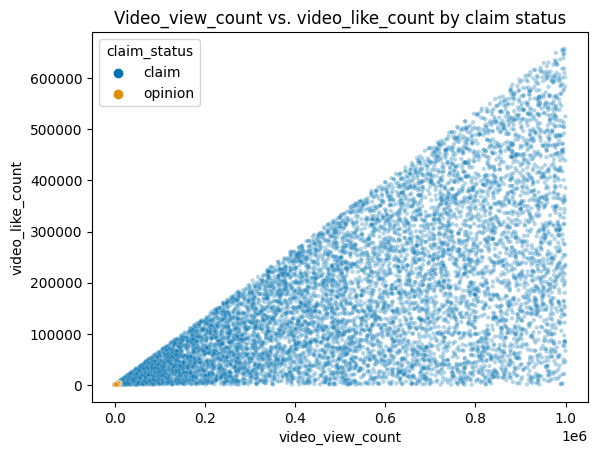

In [26]:
custom_palette = {'claim':'#56B4E9', 'opinion':'#E69F00'}

palette = sns.color_palette("colorblind", n_colors=2)

sns.scatterplot(x=data["video_view_count"], y=data["video_like_count"],
                hue=data["claim_status"], s=10, alpha=.3, palette=palette)
plt.title('Video_view_count vs. video_like_count by claim status')
plt.show()

Create a scatterplot of `video_view_count` versus `video_like_count` for opinions only

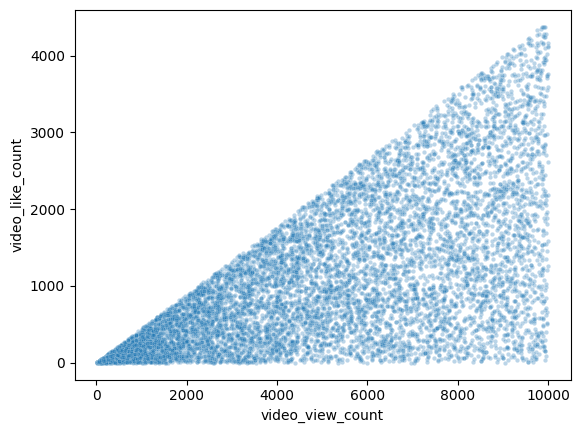

In [27]:
opinion = data[data['claim_status']=='opinion']
sns.scatterplot(x=opinion["video_view_count"],y=opinion["video_like_count"],s=10,alpha=.3)
plt.show()

## Hypothesis Testing

Checking for and handling missing values.

In [28]:
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
likes_per_view              298
comments_per_view           298
shares_per_view             298
dtype: int64

In [29]:
# Drop rows with missing values
data = data.dropna(axis=0)

In [30]:
# Rows after handling missing values
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175


We can explore the relationship between verified_status and video_view_count. One way to do this is by analyzing the average video_view_count for each verified_status group in the sample data.

In [31]:
data.groupby("verified_status")["video_view_count"].mean()

verified_status
not verified    265663.785339
verified         91439.164167
Name: video_view_count, dtype: float64

Now let's recall the distinction between the null hypothesis and the alternative hypothesis and what are ours hypotheses for this data project.

**Null Hypothesis (H0)**: There is no difference in the number of views between posts made by verified and unverified accounts on TikTok.

Any observed difference in the sample data is attributed to chance or sampling variability.

**Alternative Hypothesis (H1)**: There is a difference in the number of views between posts made by verified and unverified accounts on TikTok.

Any observed difference in the sample data reflects a real difference in the population means. 

Conduct a two-sample t-test:

- State the null hypothesis and the alternative hypothesis.
- Choose a significance level.
- Find the p-value.
- Reject or fail to reject the null hypothesis.

**H0:** There is no difference in the number of views between posts made by verified and unverified accounts on TikTok.

Any observed difference in the sample data is due to chance or sampling variability.

**H1:** There is a difference in the number of views between posts made by verified and unverified accounts on TikTok.

Any observed difference in the sample data is due to an actual difference in the corresponding population means.

We choose a 5% significance level.

In [32]:
# Save each sample in a variable
not_verified = data[data["verified_status"] == "not verified"]["video_view_count"]
verified = data[data["verified_status"] == "verified"]["video_view_count"]

# Apply a t-test using the two samples
stats.ttest_ind(a=not_verified, b=verified, equal_var=False)

TtestResult(statistic=25.499441780633777, pvalue=2.6088823687177823e-120, df=1571.163074387424)

Given that the p-value is significantly smaller than the 5% significance level, you reject the null hypothesis. This indicates that there is a statistically significant difference in the mean video view counts between verified and unverified TikTok accounts.

### **Regression Analysis**


Check for and handle duplicates

In [33]:
data.duplicated().sum()

0

Previously, we identified outliers in likes and comments using boxplots and histograms.


**Video like count outliers**

In [34]:
# Calculate the 25th and 75th percentiles
q25 = data['video_like_count'].quantile(0.25)
q75 = data['video_like_count'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
iqr = q75 - q25

# Determine the lower and upper limits for outliers
lower_bound = q25 - 1.5 * iqr
upper_bound = q75 + 1.5 * iqr

# Cap the outliers at the upper limit
data.loc[data['video_like_count'] > upper_bound, 'video_like_count'] = upper_bound

**Video comment count outliers**

In [35]:
q25 = data['video_comment_count'].quantile(0.25)
q75 = data['video_comment_count'].quantile(0.75)

iqr = q75 - q25

lower_bound = q25 - 1.5 * iqr
upper_bound = q75 + 1.5 * iqr

data.loc[data['video_comment_count'] > upper_bound, 'video_comment_count'] = upper_bound

**Class balance check**

In [36]:
# normalize= True return proportion rather than frequencies
data['verified_status'].value_counts(normalize=True)

verified_status
not verified    0.93712
verified        0.06288
Name: proportion, dtype: float64

Approximately 94.2% of the dataset comprises videos from unverified accounts, whereas only 5.8% are from verified accounts. This indicates a significant imbalance in the outcome variable.

If necessary, use resampling to achieve class balance in the outcome variable.

In [37]:
# Identify data points from majority and minority classes
data_majority = data[data["verified_status"] == "not verified"]
data_minority = data[data["verified_status"] == "verified"]

# Upsample the minority class (which is "verified")
data_minority_upsampled = resample(
    data_minority,
    replace=True,                 # to sample with replacement
    n_samples=len(data_majority), # to match majority class
    random_state=0                # to create reproducible results
)

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled]).reset_index(drop=True)

# Display new class counts
print(data_upsampled['verified_status'].value_counts())

verified_status
not verified    17884
verified        17884
Name: count, dtype: int64


Determine the average length of video transcription texts for videos posted by verified accounts, and compare it to the average length of video transcription texts for videos posted by unverified accounts.

In [38]:

data_upsampled.groupby('verified_status')['video_transcription_text'].apply(lambda texts: np.mean([len(text) for text in texts]))

verified_status
not verified    89.401141
verified        84.569559
Name: video_transcription_text, dtype: float64

Extract the length of each video_transcription_text and add it as a new column to the dataframe. This will allow the length to be used as a potential feature in the model.

In [39]:
# List comprehension iterates through each text in the column and calculate its length, assigning the results to the new text_length column
data_upsampled['text_length'] = [len(text) for text in data_upsampled['video_transcription_text']]

In [40]:
data_upsampled.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128


Let's visualize the distribution of `video_transcription_text` length for videos posted by verified accounts compared to those posted by unverified accounts.

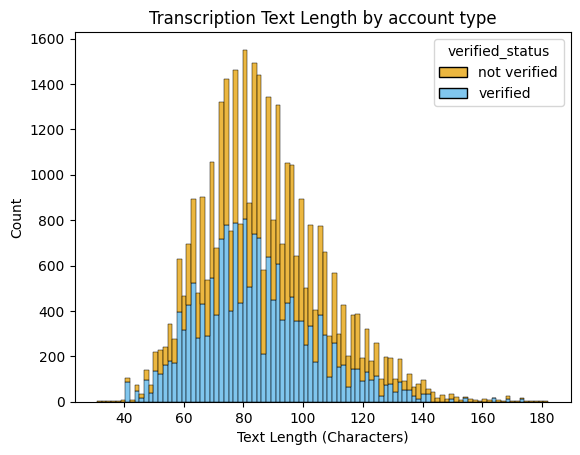

In [41]:
# Plot histogram of text lengths, differentiated by verification status

c_palette = {'not verified':'#E69F00', 'verified':'#56B4E9'}
sns.histplot(
    data=data_upsampled, 
    x='text_length', 
    hue='verified_status', 
    multiple='stack', 
    stat='count', 
    kde=False, 
    element='bars', 
    palette=c_palette,
    legend=True
)

# Customize plot
plt.title('Transcription Text Length by account type')
plt.xlabel('Text Length (Characters)');

### **Correlations Analysis**

Now, let's create a correlation matrix to identify the variables with the highest correlations.

In [42]:
data_upsampled.corr(numeric_only=True)

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length
#,1.000000,-0.000853,-0.011729,-0.697007,-0.626385,-0.504015,-0.487096,-0.608773,-0.282755,-0.311144,-0.214349,-0.193677
video_id,-0.000853,1.000000,0.011859,0.002554,0.005993,0.010515,0.008753,0.012674,-0.005539,0.005954,-0.001698,-0.007083
video_duration_sec,-0.011729,0.011859,1.000000,0.013589,0.004494,0.002206,0.003989,-0.001086,-0.003731,-0.021063,0.001244,-0.002981
video_view_count,-0.697007,0.002554,0.013589,1.000000,0.856937,0.711313,0.690048,0.748361,0.278638,0.292290,0.204884,0.244693
video_like_count,-0.626385,0.005993,0.004494,0.856937,1.000000,0.832146,0.805543,0.818032,0.565200,0.442375,0.404021,0.216693
video_share_count,-0.504015,0.010515,0.002206,0.711313,0.832146,1.000000,0.710117,0.671335,0.485643,0.389892,0.594859,0.171651
video_download_count,-0.487096,0.008753,0.003989,0.690048,0.805543,0.710117,1.000000,0.793668,0.476817,0.600509,0.343180,0.173396
video_comment_count,-0.608773,0.012674,-0.001086,0.748361,0.818032,0.671335,0.793668,1.000000,0.455890,0.634753,0.332204,0.217661
likes_per_view,-0.282755,-0.005539,-0.003731,0.278638,0.565200,0.485643,0.476817,0.455890,1.000000,0.539845,0.675187,0.094428
comments_per_view,-0.311144,0.005954,-0.021063,0.292290,0.442375,0.389892,0.600509,0.634753,0.539845,1.000000,0.394044,0.114497


**Correlation heatmap**

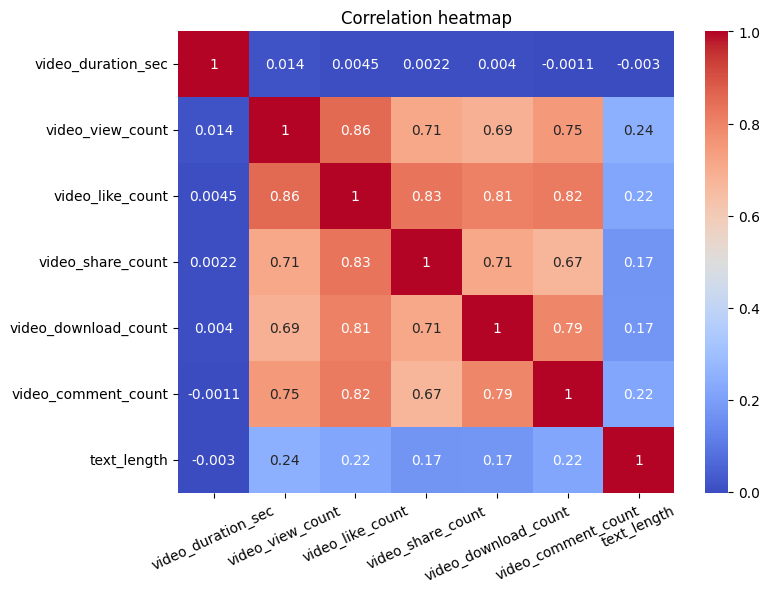

In [43]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    data_upsampled[[
        "video_duration_sec", "claim_status", "author_ban_status", "video_view_count", 
        "video_like_count", "video_share_count", "video_download_count", "video_comment_count", "text_length"
    ]].corr(numeric_only=True), 
    annot=True, 
    cmap="coolwarm"  # Using 'coolwarm' for colorblind-friendly colors
)
plt.title("Correlation heatmap")
plt.xticks(rotation=25)
plt.show()

One of the key assumptions for logistic regression is the absence of severe multicollinearity among the features. We need to keep this in mind as we analyze the heatmap and decide which features to include in our model.


The heatmap reveals a strong correlation between `video view count` and `video like count`, with a correlation coefficient of 0.86.

To meet this assumption, we could exclude the `video_like_count`.

We keep variables that measure video metrics: `video_view_count`, `video_share_count`, `video_download_count`, and `video_comment_count` as features.


**Variables selection**

Y and X variables

In [44]:
# target variable - Y
y = data_upsampled["verified_status"]

In [45]:
# Features - X
X = data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", "video_share_count", "video_download_count", "video_comment_count"]]

X.head()

,video_duration_sec,claim_status,author_ban_status,video_view_count,video_share_count,video_download_count,video_comment_count
0,59,claim,under review,343296.0,241.0,1.0,0.0
1,32,claim,active,140877.0,19034.0,1161.0,684.0
2,31,claim,active,902185.0,2858.0,833.0,329.0
3,25,claim,active,437506.0,34812.0,1234.0,584.0
4,19,claim,active,56167.0,4110.0,547.0,152.0


The # and video_id columns are not chosen as features in this case, as they do not appear to aid in predicting whether a video presents a claim or an opinion.

Train-test split

In [46]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Encode variables

In [47]:
# Check data types
X_train.dtypes

video_duration_sec        int64
claim_status             object
author_ban_status        object
video_view_count        float64
video_share_count       float64
video_download_count    float64
video_comment_count     float64
dtype: object

In [48]:
# Get unique `claim_status` values
X_train["claim_status"].unique()

array(['opinion', 'claim'], dtype=object)

In [49]:
# Get unique `author_ban_status` values
X_train["author_ban_status"].unique()

array(['active', 'under review', 'banned'], dtype=object)

As demonstrated earlier, the `claim_status` and `author_ban_status` features are currently of object data type. To utilize these categorical features with sklearn model implementations, they need to be converted to numeric values. One approach to achieve this is through one-hot encoding.

Encode categorical features in the training set

In [50]:
# Select training features to be encoded
X_train_to_encode = X_train[["claim_status", "author_ban_status"]]

# Display few encoded rows
X_train_to_encode.head()

,claim_status,author_ban_status
33058,opinion,active
20491,opinion,active
25583,opinion,active
18474,opinion,active
27312,opinion,active


In [51]:
# Initialize one-hot encoder for categorical features
X_encoder = OneHotEncoder(drop='first', sparse_output=False)

In [52]:
# Fit and transform the training features using the encoder
X_train_encoded = X_encoder.fit_transform(X_train_to_encode)

In [53]:
# Get feature names from encoder
X_encoder.get_feature_names_out()

array(['claim_status_opinion', 'author_ban_status_banned',
       'author_ban_status_under review'], dtype=object)

In [54]:
# Display first few rows of encoded training features
X_train_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [55]:
# Place encoded training features (which is currently an array) into a dataframe
X_train_encoded_df = pd.DataFrame(data=X_train_encoded, columns=X_encoder.get_feature_names_out())

# Display first few rows
X_train_encoded_df.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [56]:
# Display first few rows of `X_train` with `claim_status` and `author_ban_status` columns dropped (since these features are being transformed to numeric)
X_train.drop(columns=["claim_status", "author_ban_status"]).head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
33058,33,2252.0,23.0,4.0,0.0
20491,52,6664.0,550.0,53.0,2.0
25583,37,6327.0,257.0,3.0,0.0
18474,57,1702.0,28.0,0.0,0.0
27312,21,3842.0,101.0,1.0,0.0


In [57]:
# Concatenate `X_train` and `X_train_encoded_df` to form the final dataframe for training data (`X_train_final`)
# Remember to use `.reset_index(drop=True)` on `X_train` after removing `claim_status` and `author_ban_status`,
# to ensure that the indices match those in `X_train_encoded_df` and `count_df`.

X_train_final =pd.concat([X_train.drop(columns=['claim_status','author_ban_status']).reset_index(drop=True),X_train_encoded_df], axis=1)

X_train_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,33,2252.0,23.0,4.0,0.0,1.0,0.0,0.0
1,52,6664.0,550.0,53.0,2.0,1.0,0.0,0.0
2,37,6327.0,257.0,3.0,0.0,1.0,0.0,0.0
3,57,1702.0,28.0,0.0,0.0,1.0,0.0,0.0
4,21,3842.0,101.0,1.0,0.0,1.0,0.0,0.0


Verify the data type of the outcome variable.

In [58]:
y_train.dtypes

dtype('O')

Get unique values of outcome variable

In [59]:
y_train.unique()

array(['verified', 'not verified'], dtype=object)

As demonstrated above, the outcome variable is currently of object data type. To convert it to a numeric format, one-hot encoding can be applied.

In [60]:
# Set up an encoder for one-hot encoding the categorical outcome variable
y_encoder = OneHotEncoder(drop='first', sparse_output=False)

In [61]:
# Encode the training outcome variable

#  Adjusting the shape of `y_train` before passing into `.fit_transform()`, since it takes in 2D array
#  `flatten()` - flattens the array returned by `.fit_transform()`, so that it can be used later to train the model
y_train_final = y_encoder.fit_transform(y_train.values.reshape(-1, 1)).flatten()

y_train_final

array([1., 1., 1., ..., 1., 1., 0.])

**Model building**

In [62]:
# Build a logistic regression model and fit it to the training dataset.
log_clf = LogisticRegression(random_state=0, max_iter=800).fit(X_train_final,y_train_final)

**Results and evaluation**

In [63]:
# Select the testing features that needs to be encoded
X_test_to_encode = X_test[["claim_status", "author_ban_status"]]

X_test_to_encode.head()

,claim_status,author_ban_status
21061,opinion,active
31748,opinion,active
20197,claim,active
5727,claim,active
11607,opinion,active


In [64]:
# Transform the testing features using the encoder
X_test_encoded = X_encoder.transform(X_test_to_encode)

X_test_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [65]:
# Place encoded testing features (which is currently an array) into a dataframe
X_test_encoded_df = pd.DataFrame(data=X_test_encoded, columns=X_encoder.get_feature_names_out())

X_test_encoded_df.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,1.0,0.0,0.0


In [66]:
# Display first few rows of `X_test` with `claim_status` and `author_ban_status` columns dropped (since these features are being transformed to numeric)
X_test.drop(columns=["claim_status", "author_ban_status"]).head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
21061,41,2118.0,57.0,5.0,2.0
31748,27,5701.0,157.0,1.0,0.0
20197,31,449767.0,75385.0,5956.0,728.5
5727,19,792813.0,56597.0,5146.0,728.5
11607,54,2044.0,68.0,19.0,2.0


In [67]:
# Concatenate `X_test` and `X_test_encoded_df` to form the final dataframe for training data (`X_test_final`)
# `.reset_index(drop=True)` to reset the index in X_test after dropping `claim_status`, and `author_ban_status`,
# so that the indices align with those in `X_test_encoded_df` and `test_count_df`
X_test_final = pd.concat([X_test.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True), X_test_encoded_df], axis=1)

X_test_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,41,2118.0,57.0,5.0,2.0,1.0,0.0,0.0
1,27,5701.0,157.0,1.0,0.0,1.0,0.0,0.0
2,31,449767.0,75385.0,5956.0,728.5,0.0,0.0,0.0
3,19,792813.0,56597.0,5146.0,728.5,0.0,0.0,0.0
4,54,2044.0,68.0,19.0,2.0,1.0,0.0,0.0


Evaluate the logistic regression model by using it to generate predictions for the encoded testing set.

In [68]:
# Get predictions on the encoded testing set
y_pred= log_clf.predict(X_test_final)

Show the predictions for the encoded testing set.

In [69]:
# Display predictions
y_pred

array([1., 1., 0., ..., 1., 0., 1.])

Show the actual labels for the testing set.

In [70]:
# Display the true labels of the testing set
y_test

21061        verified
31748        verified
20197        verified
5727     not verified
11607    not verified
             ...     
14756    not verified
26564        verified
14800    not verified
35705        verified
31060        verified
Name: verified_status, Length: 8942, dtype: object

Encode the true labels of the testing set into a format that allows for comparison with the predictions.

In [71]:
# Encode the testing outcome variable

#   Adjusting the shape of `y_test` before passing into `.transform()`, since it takes in 2D array
#   flatten()` flattens the array returned by `.transform()`, so that it can be used later to compare with predictions

y_test_final = y_encoder.transform(y_test.values.reshape(-1, 1)).flatten()

y_test_final

array([1., 1., 1., ..., 0., 1., 1.])

Let's verify once more that the dimensions of the training and testing sets match, considering that additional features have been included.

In [72]:
# Get shape of each training and testing set
X_train_final.shape, y_train_final.shape, X_test_final.shape, y_test_final.shape

((26826, 8), (26826,), (8942, 8), (8942,))

**Visualize the outcomes of the model**

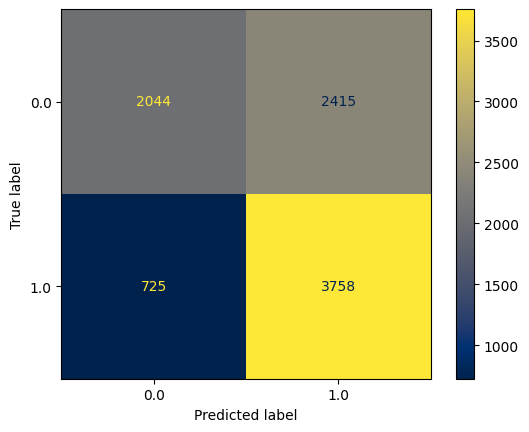

In [73]:
# Calculate values for confusion matrix
log_cm = confusion_matrix(y_test_final, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(cmap='cividis');

Generate a classification report that encompasses precision, recall, F1-score, and accuracy metrics to assess the performance of the logistic regression model.

**Classification report**

In [74]:
# Define your target labels
target_labels = ['verified', 'not verified']

# Generate the classification report as a dictionary
report_dict = classification_report(y_test_final, y_pred, target_names=target_labels, output_dict=True)

# Convert the dictionary into a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Print the DataFrame
print(report_df)

              precision    recall  f1-score      support
verified       0.738173  0.458399  0.565578  4459.000000
not verified   0.608780  0.838278  0.705330  4483.000000
accuracy       0.648848  0.648848  0.648848     0.648848
macro avg      0.673476  0.648338  0.635454  8942.000000
weighted avg   0.673303  0.648848  0.635642  8942.000000


Display the feature names and corresponding model coefficients from a trained logistic regression model 

In [75]:
# Create a DataFrame with feature names and model coefficients
# log_clf is an instance of a logistic regression classifier that has been trained on a dataset.
pd.DataFrame(data={'Feature Name':log_clf.feature_names_in_,'Model Coefficients':log_clf.coef_[0]})

,Feature Name,Model Coefficients
0,video_duration_sec,8.607893e-03
1,video_view_count,-2.132079e-06
2,video_share_count,5.930971e-06
3,video_download_count,-1.099775e-05
4,video_comment_count,-6.404235e-04
5,claim_status_opinion,3.908384e-04
6,author_ban_status_banned,-1.781741e-05
7,author_ban_status_under review,-9.682447e-07


# **Machine Learning for Video Classification**

## **PACE: Construct**

### **Feature engineering**

Extract the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [76]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data['text_length'] = data['video_transcription_text'].str.len()

# or use .apply() function with list comprehension
# data['video_transcription_text'].apply(func= lambda x: len(x))

Calculate the average text_length for claims and opinions.

In [77]:
# Calculate the average text_length for claims and opinions
data[['text_length','claim_status']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


Visualize the distribution of `text_length` for claims and opinions.

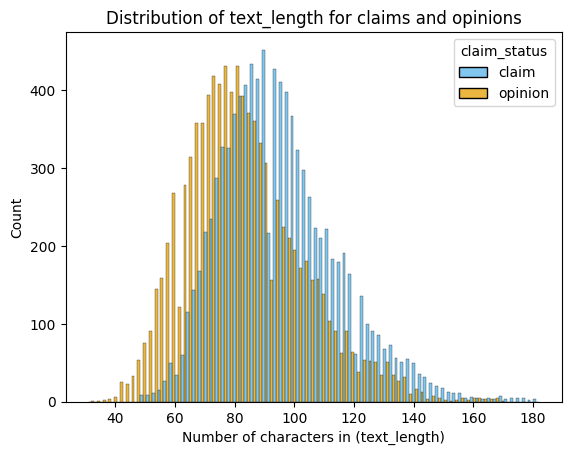

In [78]:
# Suppress the specific warning

# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot
c_palette = {'opinion':'#E69F00', 'claim':'#56B4E9'}

sns.histplot(data=data, stat='count', hue='claim_status', multiple='dodge', x='text_length', 
              kde=False, legend=True, element='bars', palette=c_palette
             )
plt.title('Distribution of text_length for claims and opinions')
plt.xlabel('Number of characters in (text_length)')
plt.show()

The letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos generally have a higher character count, averaging about 13 more characters than opinion videos, as noted in a previous analysis.

### **Feature selection and transformation**

Encode target and catgorical variables.

In [79]:
# Create a copy of the X data
X=data.copy

# Drop unnecessary columns
X=data.drop(['#', 'video_id'],axis=1)

# Encode target variable
X['claim_status'] = X['claim_status'].map({'opinion':0, 'claim':1})

# Dummy encode remaining categorical values
X = pd.get_dummies(X, columns=['verified_status', 'author_ban_status'], 
                   drop_first=True)
X.head(10)

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.000,241.0,1.0,0.0,0.056584,0.000000,0.000702,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.000,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.000,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.000,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.000,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128,False,False,False
5,1,35,someone shared with me that gross domestic pro...,336647.0,175546.000,62303.0,4293.0,728.5,0.521454,0.005516,0.185069,127,False,False,True
6,1,16,someone shared with me that elvis presley has ...,750345.0,311333.875,193911.0,8616.0,728.5,0.647958,0.007258,0.258429,95,False,False,False
7,1,41,someone shared with me that the best selling s...,547532.0,1072.000,50.0,22.0,11.0,0.001958,0.000020,0.000091,99,False,False,False
8,1,50,someone shared with me that about half of the ...,24819.0,10160.000,1050.0,53.0,27.0,0.409364,0.001088,0.042306,103,False,False,False
9,1,45,someone shared with me that it would take a 50...,931587.0,171051.000,67739.0,4104.0,728.5,0.183612,0.002727,0.072714,102,True,False,False


### **Split the data**

Assign 'claim_status' as a target variable.

In [80]:
# Isolate target variable
y=X['claim_status']

Isolate the features.

In [81]:
# Isolate features
X=X.drop(['claim_status'], axis=1)

X.head(10)

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.000,241.0,1.0,0.0,0.056584,0.000000,0.000702,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.000,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.000,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.000,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.000,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128,False,False,False
5,35,someone shared with me that gross domestic pro...,336647.0,175546.000,62303.0,4293.0,728.5,0.521454,0.005516,0.185069,127,False,False,True
6,16,someone shared with me that elvis presley has ...,750345.0,311333.875,193911.0,8616.0,728.5,0.647958,0.007258,0.258429,95,False,False,False
7,41,someone shared with me that the best selling s...,547532.0,1072.000,50.0,22.0,11.0,0.001958,0.000020,0.000091,99,False,False,False
8,50,someone shared with me that about half of the ...,24819.0,10160.000,1050.0,53.0,27.0,0.409364,0.001088,0.042306,103,False,False,False
9,45,someone shared with me that it would take a 50...,931587.0,171051.000,67739.0,4104.0,728.5,0.183612,0.002727,0.072714,102,True,False,False


### **Create training, validation, and test sets**

Split data into training and testing sets, 80/20.

In [82]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [83]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

Ensure that the dimensions of the training, validation, and testing sets are consistent.

In [84]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 14), (3817, 14), (3817, 14), (11450,), (3817,), (3817,))

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

### **Tokenize text column**

The feature video_transcription_text is a text-based variable and is not categorical because it does not have a predetermined set of possible values. To convert this text into numerical features, a common method is to apply a bag-of-words approach, such as using the CountVectorizer.

CountVectorizer operates by dividing text into n-grams, which are sequences of n consecutive words. Each n-gram represents a sequence of adjacent words from the original text, capturing relationships between consecutive words.

In [85]:
# Initialize  `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(
                ngram_range=(2, 3),    # Generates 2-grams and 3-grams (i.e., sequences of 2 or 3 consecutive words)
                max_features=15,       # Limits the vocabulary to the top 15 most frequent n-grams.
                stop_words='english'   # Excludes common English stop words (e.g., 'the', 'and') from the vocabulary.
                )  
# Dsiplay CountVectorizer
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

Fit the vectorizer to the training data to generate the n-grams and transform the data to count their occurrences. Ensure that the vectorizer is fitted only on the training data and not on the validation or test data.

In [86]:
# Fit the vectorizer to the training data to learn the vocabulary and generate n-grams,
# then transform the training text data into a numerical format with occurrence counts.
# Convert the resulting sparse matrix to a dense array.
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()

count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [87]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first few rows
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [88]:
# Combine `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,0.124648,0.000000,0.008042,134,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,0.029896,0.000245,0.003156,97,False,True,False,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,0.017799,0.000085,0.002162,76,False,False,True,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,0.180638,0.000433,0.047593,58,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,0.174097,0.000264,0.016618,57,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [89]:
# Combine the original training features (excluding 'video_transcription_text') with the new numerical features 
# derived from the vectorizer into a single DataFrame. 
# Reset the index to ensure proper alignment with `count_df` and concatenate along the columns axis.
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

In [90]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [91]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [92]:
# Combine `X_val` and `validation_count_df` to crate the final dataframe for validation data (`X_val_final`)
# `.reset_index(drop=True)`ensures that the index is reset in `X_val` after dropping the `video_transcription_text` column,
# aligning the indices with those in `validation_count_df`.
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Display first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,311333.875,14612.0,6591.0,44.0,0.655730,0.000076,0.025241,72,False,False,True,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.000,311.0,13.0,1.0,0.273221,0.000160,0.049720,96,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.000,26235.0,2060.0,728.5,0.608530,0.003051,0.063932,88,False,False,False,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.000,1230.0,564.0,248.0,0.063862,0.000609,0.003023,83,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.000,25320.0,3331.0,728.5,0.142063,0.000995,0.026034,104,False,False,True,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Apply the same vectorizer to the test data to obtain n-gram counts. Ensure that the vectorizer is only used for transformation and not refitted.

In [93]:
# Convert `video_transcription_text` from the test set into numerical features using the fitted vectorizer
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Create a DataFrame from the numerical features, using the feature names provided by the vectorizer
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Combine the transformed numerical features with the remaining columns from `X_test` to create the final testing dataset
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.000,16591.0,622.0,312.0,0.196444,0.000451,0.023973,107,False,False,False,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.000,36.0,17.0,1.0,0.359799,0.000194,0.006971,69,True,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,311333.875,57608.0,8578.0,728.5,0.429157,0.003669,0.071835,90,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.000,847.0,17.0,5.0,0.359932,0.000778,0.131747,76,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.000,15348.0,252.0,91.0,0.192276,0.000164,0.027615,72,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Random Forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [94]:
# Instantiate the random forest classifier with a fixed random seed for reproducibility
rf = RandomForestClassifier(random_state=0)

# Define a dictionary with hyperparameters to tune for cross-validation
cv_params = {
    'max_depth': [5, 7, None],              # Options for the maximum depth of the tree
    'max_features': [0.3, 0.6],             # Proportion of features to consider for splits
    # 'max_features': 'auto'                # Alternative option for feature selection
    'max_samples': [0.7],                   # Proportion of samples to use for fitting each base estimator
    'min_samples_leaf': [1, 2],             # Minimum number of samples required to be at a leaf node
    'min_samples_split': [2, 3],            # Minimum number of samples required to split an internal node
    'n_estimators': [75, 100, 200],         # Number of base estimators in the ensemble
}

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [95]:
%%time
# Fit the model
rf_cv.fit(X_train_final, y_train)

CPU times: user 10min 45s, sys: 1.54 s, total: 10min 47s
Wall time: 10min 47s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'accuracy', 'f1', 'recall', 'precision'})

In [96]:
# Output the best recall score achieved during cross-validation
rf_cv.best_score_

0.9958582006702817

In [97]:
# Output the best hyperparameters found during cross-validation
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

This model demonstrates exceptional performance, achieving an average recall score of 0.995 across five cross-validation folds. Upon verifying the precision score to ensure the model is not classifying all samples as claims, it is evident that the model is making nearly perfect classifications.

### XGBoost model

In [98]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [99]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: user 5min 44s, sys: 3.99 s, total: 5min 48s
Wall time: 1min 32s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'accuracy', 'f1', 'recall', 'precision'})

In [100]:
# Examine best recall score
xgb_cv.best_score_

0.9913708291794634

In [101]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 300}

This model delivers exceptional performance. Despite its recall score being slightly lower than the random forest model's, its precision score is flawless.

## **PACE: Execute**

### Model evaluation

Evaluate models against validation criteria.

#### **Random forest model**

In [102]:
# Use the random forest "best estimator" model to get predictions on the encoded testing set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

Display the predictions on the encoded testing set.

In [103]:
# Display the predictions on the encoded testing set
y_pred

array([1, 0, 1, ..., 1, 1, 1])

Display the true labels of the testing set.

In [104]:
# Display the true labels of the testing set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

Create a confusion matrix to visualize the results of the classification model.

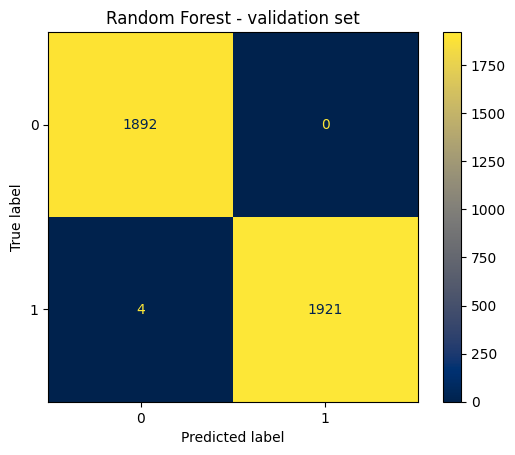

In [105]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot(cmap='cividis')

plt.title('Random Forest - validation set');

In the confusion matrix:

- The upper-left quadrant represents the count of true negatives, indicating the number of opinions correctly classified as opinions by the model.
- The upper-right quadrant shows the number of false positives, which are opinions incorrectly classified as claims.
- The lower-left quadrant reflects the number of false negatives, representing claims incorrectly classified as opinions.
- The lower-right quadrant displays the count of true positives, representing claims correctly classified as claims.
An ideal model would result in only true negatives and true positives, with no false negatives or false positives.

As illustrated by the confusion matrix, this model achieves perfect performance with no false negatives.

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

In [106]:
# Create classification report for random forest model
target_labels =['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



The classification report above demonstrates that the random forest model achieved nearly perfect scores. According to the confusion matrix, there were 4 misclassifications in total, that come from false positives quadrant.

#### **XGBoost model**

In [107]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

In [108]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

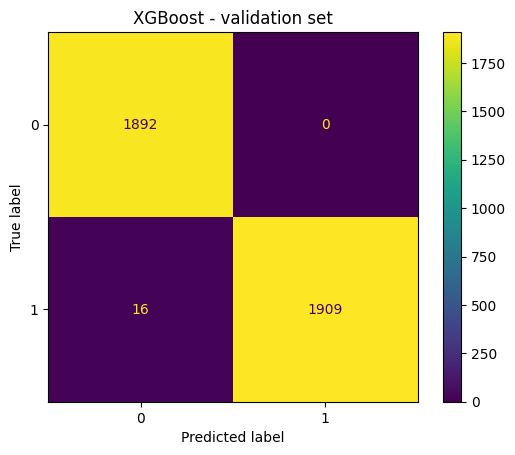

In [109]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()

In [110]:
# Create classification report for XGBoost model
target_labels =['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1892
       claim       1.00      0.99      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



The results from the XGBoost model were almost flawless, but it frequently produced false negatives. Since identifying claims is crucial, it’s essential for the model to effectively capture all actual claim videos. The random forest model, with its superior recall score, is therefore considered the best-performing model.

### **Use champion model to predict on test data**

Both the Random Forest and XGBoost model architectures yielded near-perfect results. However, in this instance, the Random Forest model performed slightly better, making it the preferred model.

In [111]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test_final)

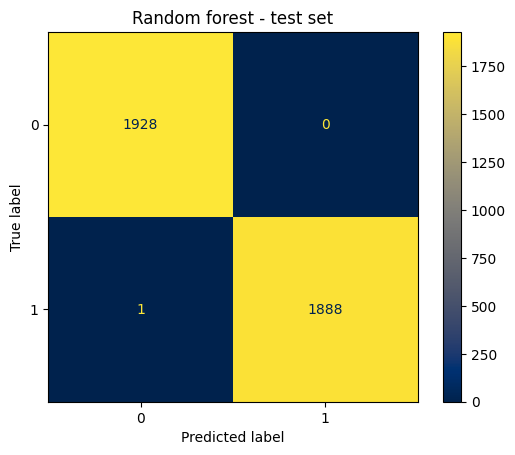

In [112]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot(cmap='cividis')

# Display plot
plt.title('Random forest - test set');
plt.show()

#### **Feature importances of champion model**


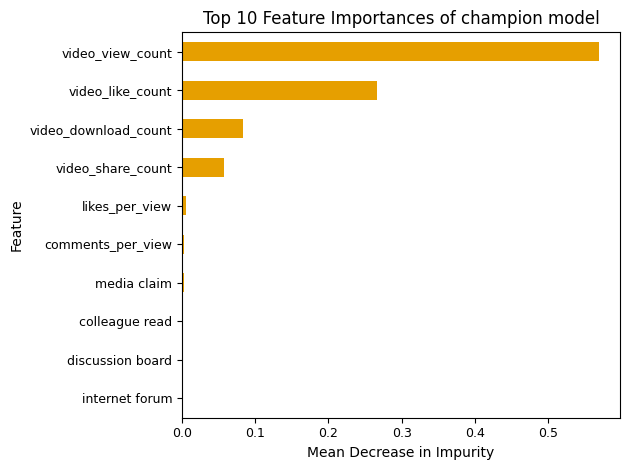

In [113]:
# Extract the feature importances from the best estimator of the random forest cross-validation model
importances = rf_cv.best_estimator_.feature_importances_

# Create a Pandas Series to hold the feature importances, using the column names from the test dataset as the index
rf_importances = pd.Series(importances, index=X_test_final.columns)

# Sort the feature importances in descending order and select the top 10
top_10_rf_importances = rf_importances.sort_values(ascending=False).head(10).sort_values(ascending=True)

# Colorblind-friendly color
colorblind_color = "#E69F00"

# Create the horizontal bar plot
fig, ax = plt.subplots()
top_10_rf_importances.plot.barh(ax=ax, color=colorblind_color)  # Create a horizontal bar plot

# Set the plot title and labels
ax.set_title('Top 10 Feature Importances of champion model', fontsize=12)
ax.set_xlabel('Mean Decrease in Impurity')
ax.set_ylabel('Feature')

# Set y-ticks font size
ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=9)

# Adjust layout for better fit
fig.tight_layout()

# Display the plot
plt.show()

The most predictive features were all related to the engagement levels generated by the video. This aligns with prior exploratory data analysis, which indicated a strong correlation between engagement metrics and the model's predictions.

###  Final Project Conclusion

**Recommendation on Model Usage:**

We recommend using the current model due to its exceptional performance across both validation and test datasets. It consistently achieved high precision and F1 scores, reflecting its strong capability in accurately classifying both claims and opinions.

**Model Functionality and Prediction Mechanism:**

The model's effectiveness stems from its reliance on user engagement metrics. It primarily classifies videos based on features such as the number of views, likes, shares, and downloads. These engagement indicators were found to be the most predictive features for determining the video classifications.

**Future Feature Engineering:**

Given the model's near-perfect performance, there is no immediate need for additional feature engineering. However, for potential future improvements, incorporating features such as the number of times a video was reported and the total number of user reports across all videos by each author could be beneficial. These additional metrics might provide further insights and enhance the model’s predictive capabilities.

It is important to acknowledge that there are instances when the data we have may not effectively predict the target variable. This is a natural occurrence in data science. While machine learning is a robust and valuable tool, it is not infallible. If the data lacks a meaningful predictive signal, even the most advanced algorithms will struggle to produce reliable and accurate predictions. Embracing this reality and drawing appropriate conclusions is an essential aspect of our analytical process.